In [49]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['axes.unicode_minus']=False

import warnings
warnings.filterwarnings('ignore')

In [50]:
train = pd.read_csv('train.csv', parse_dates=['datetime'])
train.shape

(10886, 12)

In [51]:
test = pd.read_csv('test.csv', parse_dates=['datetime'])
test.shape

(6493, 9)

# Feature Engineering 

In [52]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['minute'] = train['datetime'].dt.minute
train['second'] = train['datetime'].dt.second
train['dayofweek'] = train['datetime'].dt.dayofweek
train.shape

(10886, 19)

In [53]:
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day'] = test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['minute'] = test['datetime'].dt.minute
test['second'] = test['datetime'].dt.second
test['dayofweek'] = test['datetime'].dt.dayofweek
test.shape

(6493, 16)

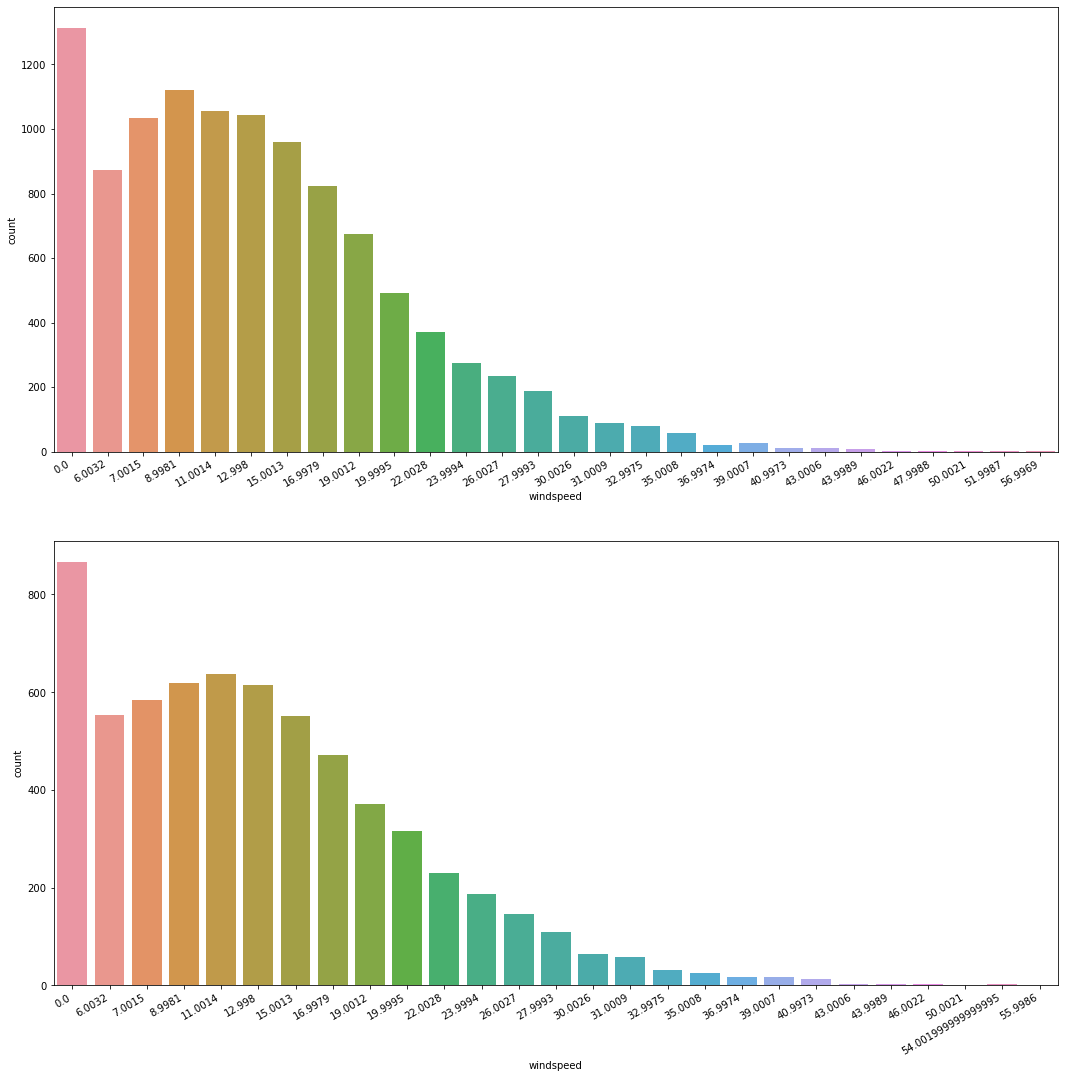

In [54]:
# 측정하지 않은 것을 0으로 채운것이 아닐까?

f, ax = plt.subplots(2, figsize=(18,18))
# plt.sca(ax[0])
ax[0].set_xticklabels(labels='windspeed',rotation=30, ha='right')
sns.countplot('windspeed', data=train, ax=ax[0])
ax[0].set_ylabel = 'count'
ax[0].set_title = 'train windspeed'

plt.sca(ax[1])
plt.xticks(rotation=30, ha='right')
sns.countplot('windspeed', data=test, ax=ax[1])
ax[1].set_ylabel = 'count'
ax[1].set_title = 'train windspeed'

In [55]:
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
trainWind0.shape

(1313, 19)

In [56]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
    
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]

    
    dataWindNot0['windspeed'] = dataWindNot0['windspeed'].astype('str')
    
    model = RandomForestClassifier()
    model.fit(dataWindNot0[wCol], dataWindNot0['windspeed'])
    wind0Values = model.predict(X=dataWind0[wCol])
    
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    
    predictWind0['windspeed'] = wind0Values
    
    data = predictWindNot0.append(predictWind0)
    
    data['windspeed'] = data['windspeed'].astype('float')
    
    data.reset_index(inplace=True)
    data.drop(['index'], inplace=True, axis=1)
    return data

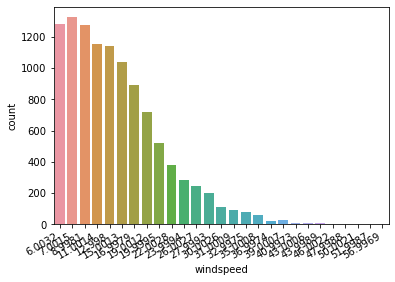

In [57]:
train = predict_windspeed(train)

f, ax = plt.subplots()

ax.set_xticklabels(labels='windspeed',rotation=30, ha='right')
sns.countplot('windspeed', data=train, ax=ax)
ax.set_ylabel='count'
ax.set_title = 'train windspeed'

In [58]:
categorical_feature_names = ['season','holiday','workingday',
                            'weather','dayofweek','month','year','hour']

for var in categorical_feature_names:
    train[var] = train[var].astype('category')
    test[var] = test[var].astype('category')

In [59]:
feature_names = ['season','weather','temp','atemp','humidity','windspeed',
                'year','hour','dayofweek','holiday','workingday']
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [61]:
X_train = train[feature_names]
X_train.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,2,9.84,12.880,75,6.0032,2011,5,5,0,0
1,1,1,15.58,19.695,76,16.9979,2011,10,5,0,0
2,1,1,14.76,16.665,81,19.0012,2011,11,5,0,0
3,1,1,17.22,21.210,77,19.0012,2011,12,5,0,0
4,1,2,18.86,22.725,72,19.9995,2011,13,5,0,0


In [62]:
X_test = test[feature_names]
X_test.head()

,season,weather,temp,atemp,humidity,windspeed,year,hour,dayofweek,holiday,workingday
0,1,1,10.66,11.365,56,26.0027,2011,0,3,0,1
1,1,1,10.66,13.635,56,0.0000,2011,1,3,0,1
2,1,1,10.66,13.635,56,0.0000,2011,2,3,0,1
3,1,1,10.66,12.880,56,11.0014,2011,3,3,0,1
4,1,1,10.66,12.880,56,11.0014,2011,4,3,0,1


In [64]:
label_name = 'count'

y_train = train[label_name]

y_train.head()

0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [81]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [78]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

In [79]:
from sklearn.ensemble import RandomForestRegressor
max_depth_list =[]
model = RandomForestRegressor(n_estimators=100, random_state=0)

model

RandomForestRegressor(random_state=0)

In [80]:
%time score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring=rmsle_scorer)
score = score.mean()
print(score)

Wall time: 37.1 s
0.3307833672894286


In [82]:
model.fit(X_train,y_train)

RandomForestRegressor(random_state=0)

In [83]:
predictions = model.predict(X_test)

predictions.shape

(6493,)

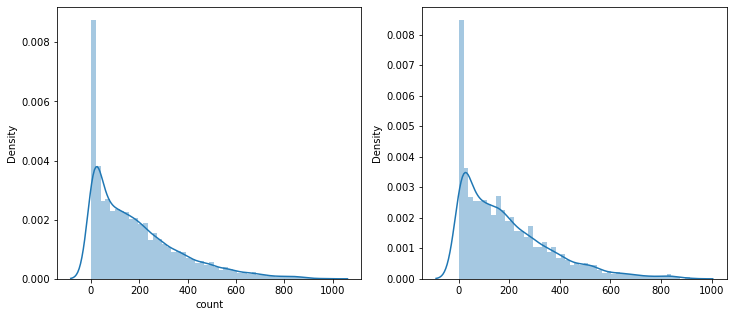

In [85]:
f, ax = plt.subplots(1,2,figsize=(12,5))

sns.distplot(y_train, ax=ax[0],bins=50)
ax[0].set_title='train'

sns.distplot(predictions, ax=ax[1],bins=50)
ax[1].set_title='test'

In [87]:
submission = pd.read_csv('sampleSubmission.csv')
submission['count'] = predictions

submission.head()

,datetime,count
0,2011-01-20 00:00:00,12.72
1,2011-01-20 01:00:00,5.09
2,2011-01-20 02:00:00,4.28
3,2011-01-20 03:00:00,3.52
4,2011-01-20 04:00:00,3.14


In [89]:
submission.to_csv(f'Score_{score:.5f}_submission.csv', index=False)